In [3]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [4]:
img_path = "/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/images/train2017/000000410343.jpg"
# 000000245417.jpg
# 000000245415.jpg


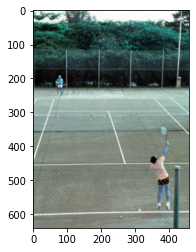

In [9]:
# Show images
image = cv2.imread(img_path)
plt.imshow(image)
plt.show()


In [59]:
# gaussian heatmap
 
def gaussian_heatmap(image_size, center_point, confidence):
    mu = 0.0
    sigma = confidence*10
    ro = 0

    center_x = center_point[0]
    center_y = center_point[1]

    grid_y, grid_x = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))

    x = grid_x - center_x
    y = grid_y - center_y

    return np.exp(-1 * (x ** 2 - 2 * ro * x * y + y**2) / (2 * (1 - ro**2)))

In [19]:
keypoint_name = ["nose", "left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder", "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee", "left_ankle", "right_ankle"],


In [48]:
import json
file = open('/home/sojeong/CV/deep-high-resolution-net.pytorch/data/coco/annotations/person_keypoints_train2017.json')
data = json.load(file)

target_data = data['annotations'][2]
key_point_data = target_data['keypoints']
bounding_box = target_data['bbox']


In [51]:
bounding_box #[x,y,width, height]

[276.12, 0.29, 61.18, 118.73]

In [46]:

keypoint = []
keypoint_confidence = []
for i, k in enumerate(key_point_data):
    if i%3 != 0:
        continue
    if k != 0:
        coordinate = (key_point_data[i], key_point_data[i+1])
        confidence = key_point_data[i+2]
        keypoint.append(coordinate)
        keypoint_confidence.append(confidence)

print(keypoint)
print(keypoint_confidence)


[(322, 20), (290, 11), (316, 87), (286, 76)]
[2, 2, 2, 2]


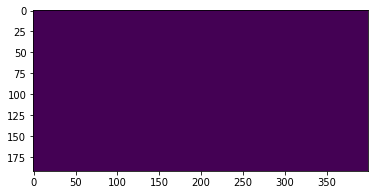

In [68]:
h1 = gaussian_heatmap((400, 192), keypoint[0], keypoint_confidence[0])
h2 = gaussian_heatmap((400, 192), keypoint[1], keypoint_confidence[1])

plt.figure()
plt.imshow(h1)
plt.savefig('heatmap.png')